### Code for running experiments, plotting them and performing statistical tests

In [13]:
from importlib import reload
import LambdaRankHW
import numpy as np
import query
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sklearn.tests as st
import scipy.stats as st
import seaborn as sns

DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/Dana/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpraqk_ayy/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/Dana/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpraqk_ayy/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce 940MX (CNMeM is enabled with initial size: 80.0% of memory, CuDNN 5110)
C:\Users\Dana\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your CuDNN version is more recent then Theano. If you see problems, try updating Theano or downgrading CuDNN to version 4.
  warnings.warn(warn)
C:\Users\Dana\Anaconda3\lib\site-packages\theano\tensor\signal\do

In [11]:
def sign_binomial_test(proportions, threshold = 0.5, verbose=True, allow_ties=False, alternative = 'two-sided', sig = 0.05):
  k = len(np.where(proportions > threshold)[0])
  
  if alternative == 'two-sided':
    sig /= 2
    
  if allow_ties:
    N = len(proportions)
  else:
    num_ties = len(np.where(proportions == threshold)[0])
    N = len(proportions) - num_ties
    
  if verbose:
    print('Running %s Binomial test on k = %s, n = %s' % (alternative, k, N))
    print('Percentage of examples where E>P: %s' % (k * 1.0 / N))

  pval = st.binom_test(k, N, 0.5, alternative)

  if verbose:
    if pval < sig:
      print('Should reject H0 given p-val = %s ' % (pval))
    else:
      print('Not enough evidence to reject H0 given p-val = %s \n' % (pval))
  
  return pval

In [5]:
# Runs a full experiment on one model with the given setup, reports test ndcgs and pickles the results
def full_experiment(n_epochs, model_type, num_features, num_folds, save_models):

    results, best_ranker = LambdaRankHW.experiment(n_epochs, model_type, num_features, num_folds)

    print('Loading all test queries')
    test_queries = {}
    for fold in range(1,6):
        test_queries = {**test_queries, **query.load_queries(os.path.normpath('./HP2003/Fold%d/test.txt' % fold), num_features)}


    print('Running test mndcg')
    test_results= LambdaRankHW.report_test_ndcg(best_ranker, test_queries)
    print('Test mNDCG: %f' % (sum(list(test_results.values()))/len(test_queries)))

    if save_models:
        with open('./results_%s_epochs%s_kfold%s' % (model_type, n_epochs, num_folds), 'wb') as f:
            pickle.dump(results, f)
            pickle.dump(test_results,f)
        
    data = []

    for fold in range(1,len(results)+1):
        for e_num in range(n_epochs):
            for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
                epoch_dict = results[fold-1][e_num]
                aux = [e_num + 1, fold, measure, epoch_dict[measure]]
                data.append(aux)

    df = pd.DataFrame(data, columns=['Epoch', 'Fold', 'Measure', 'Value'])

    return df

In [19]:
# Superior plots
def plot_results(df, measure_type, num_epochs, save_plots):
    ls = []
    for i in range(n_epochs):
        if i%10 == 0:
            ls.append(i)
        else:
            ls.append('')

    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
        ax = sns.pointplot(x="Epoch", y="Value", hue="Fold", data=df.loc[df['Measure'] == measure], ci=None)
        if  measure == 'train_loss':
            ax.set(ylabel='Utility')
        else:
            ax.set(ylabel=measure)
        ax.set_xticklabels(ls)
        #ax.set(xticklabels=[i*10 for i in range(int(n_epochs/10))])
        if save_plots:
            plt.savefig('./%s_%s_%s.png' % (measure_type, measure, num_epochs))
        plt.show()

    plt.figure()
    ax = sns.pointplot(x="Epoch", y="Value", hue='Measure',
                  data=df.loc[df['Measure'].isin(['train_mndcg', 'val_mndcg'])], ci=95)
    ax.set_xticklabels(ls)
    if save_plots:
        plt.savefig('./%s_%s_%s.png' % (measure_type, 'mean_train_val', num_epochs))
    plt.show()

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.239s
training loss:		0.005230
training mNDCG:		0.410493
Lambda Count 0
validation mNDCG:		0.458768

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.236s
training loss:		0.015964
training mNDCG:		0.138482
Lambda Count 0
validation mNDCG:		0.098978

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.237s
training loss:		0.005206
training mNDCG:		0.288203
Lambda Count 0
validation mNDCG:		0.291557

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.247s
training loss:		0.011933
training mNDCG:		0.410138
Lambda Count 0
validation mNDCG:		0.316544

Loading train queries
Loading va

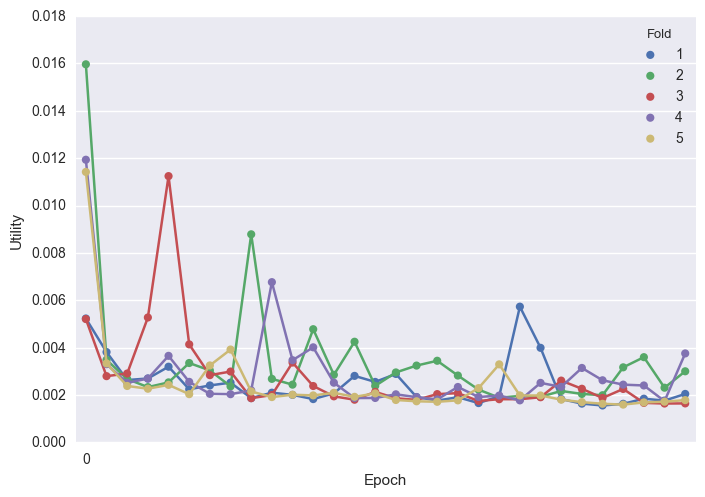

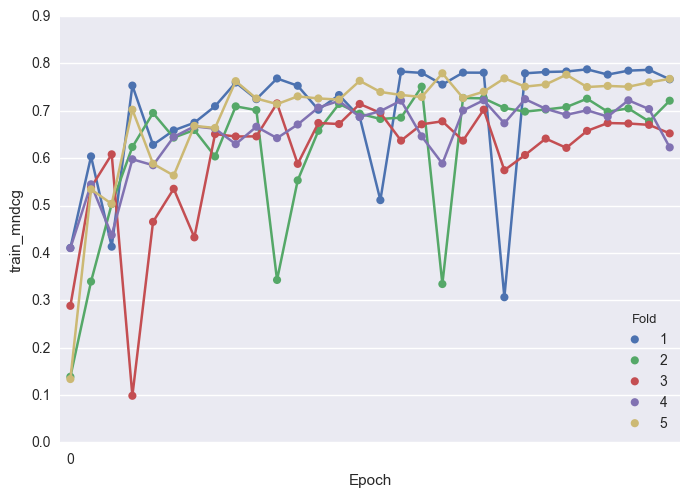

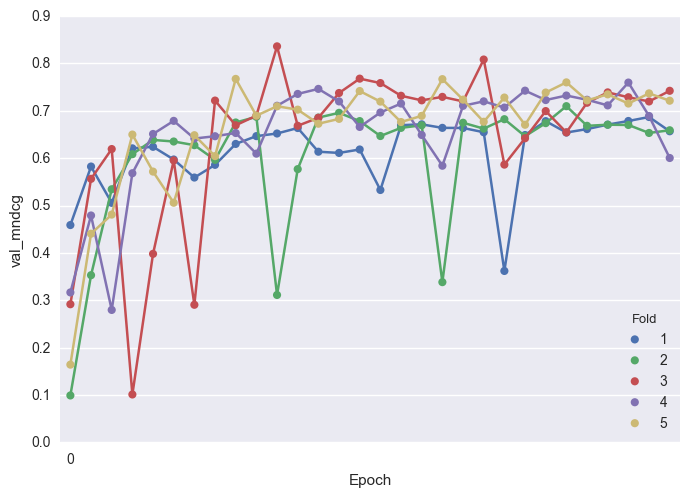

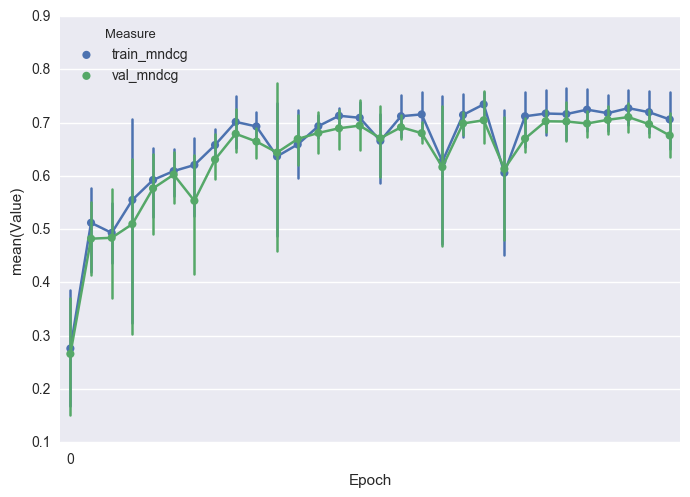

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.590s
training loss:		-86.614624
training mNDCG:		0.804908
Lambda Count 114989
validation mNDCG:		0.668307

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.582s
training loss:		-106.176338
training mNDCG:		0.774579
Lambda Count 116091
validation mNDCG:		0.743927

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.549s
training loss:		-85.911530
training mNDCG:		0.738610
Lambda Count 100457
validation mNDCG:		0.855074

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 0.572s
training loss:		-93.681648
training mNDCG:		0.748598
Lambda Count 102263
validation mNDCG:		0.838196

Loa

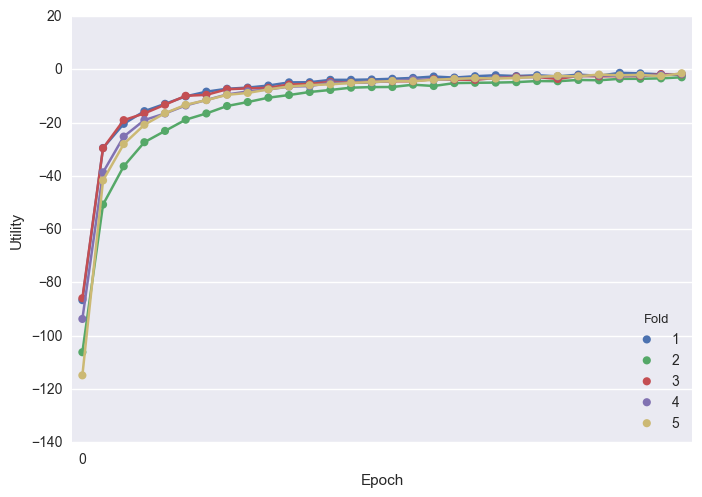

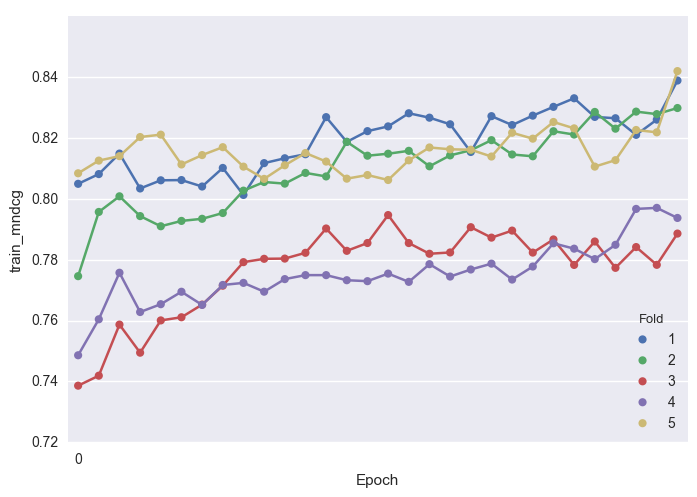

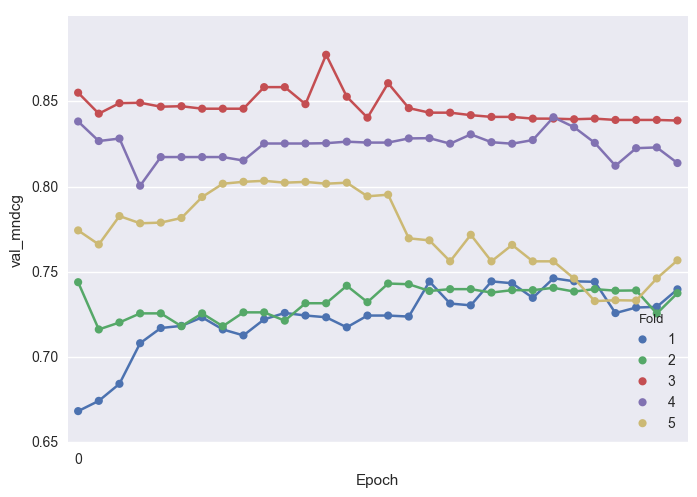

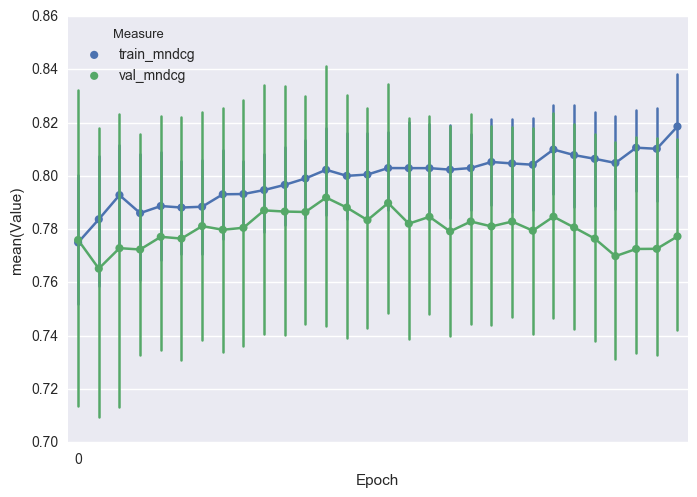

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 1.293s
training loss:		-33.723938
training mNDCG:		0.811947
Lambda Count 114989
validation mNDCG:		0.680833

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 1.401s
training loss:		-34.591278
training mNDCG:		0.754478
Lambda Count 116091
validation mNDCG:		0.759992

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 1.251s
training loss:		-28.933947
training mNDCG:		0.740482
Lambda Count 100457
validation mNDCG:		0.843803

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 30 took 1.133s
training loss:		-29.934956
training mNDCG:		0.759286
Lambda Count 102263
validation mNDCG:		0.817638

Load

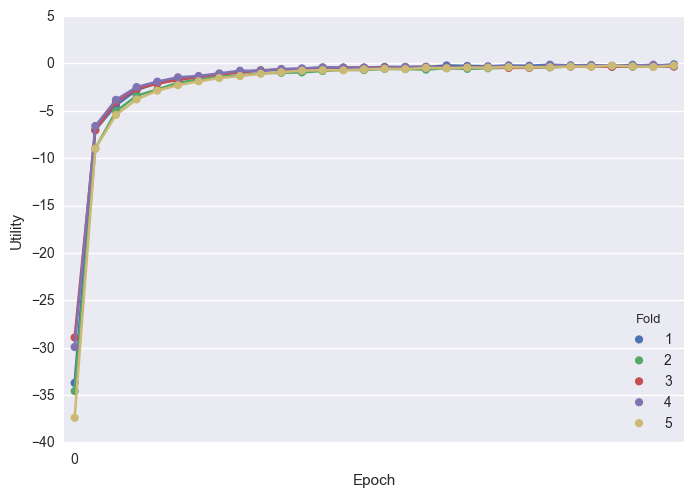

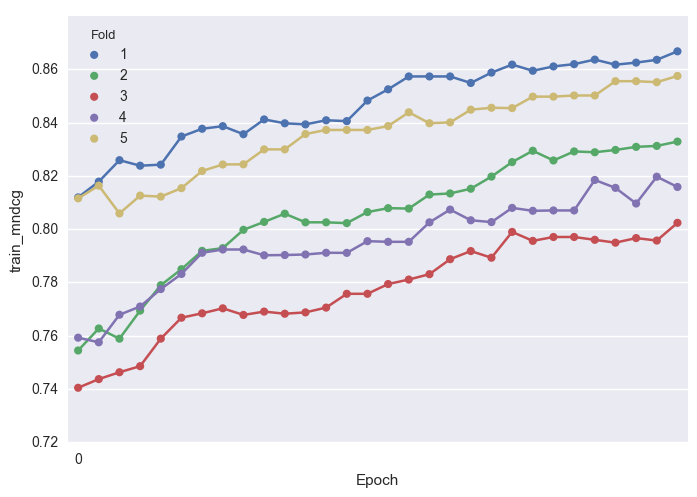

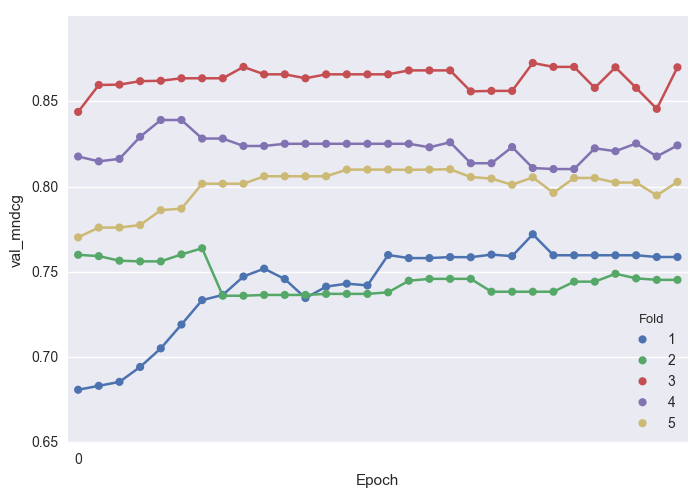

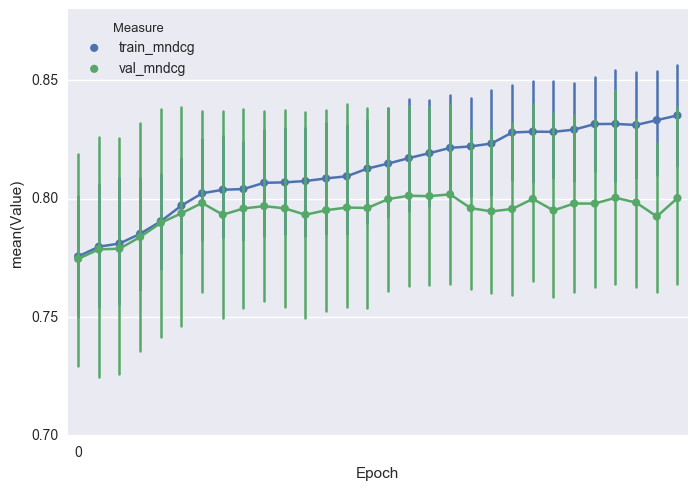

In [10]:
# run everything
n_epochs = 30
types = [LambdaRankHW.POINTWISE, LambdaRankHW.PAIRWISE, LambdaRankHW.LISTWISE]
num_features = 64
num_folds = 5
save_models = True
save_plots = True

for model_type in types:
    df = full_experiment(n_epochs, model_type, num_features, num_folds, save_models)
    plot_results(df, model_type, n_epochs, save_plots)


In [12]:
# Load data for 30 epochs

with open('./results_pointwise_epochs30_kfold5', 'rb') as f:
    pointwise_results = pickle.load(f)
    pointwise_test = pickle.load(f)
    
with open('./results_pairwise_epochs30_kfold5', 'rb') as f:
    pairwise_results = pickle.load(f)
    pairwise_test = pickle.load(f)
    
with open('./results_listwise_epochs30_kfold5', 'rb') as f:
    listwise_results = pickle.load(f)
    listwise_test = pickle.load(f)

In [27]:
# Best ranker for pointwise
max_val = 0
best_fold = 0
for f, fold in enumerate(pointwise_results):
    if fold[-1]['val_mndcg'] > max_val:
        max_val = fold[-1]['val_mndcg']
        best_fold = f+1
    print(f+1,fold[-1])
print("Best fold", best_fold, max_val)

test_point_queries = query.load_queries(os.path.normpath('./HP2003/Fold%d/test.txt' % best_fold), num_features)
point_test_res = [pointwise_test[query.get_qid()] for query in test_point_queries]
print('Pointwise best ranker test mNDCG:',np.mean(point_test_res))

1 {'val_mndcg': 0.65679870234556825, 'train_mndcg': 0.76651652464614373, 'train_loss': 0.0020442898, 'number': 30}
2 {'val_mndcg': 0.65892653202075835, 'train_mndcg': 0.72133949542752351, 'train_loss': 0.0030001253, 'number': 30}
3 {'val_mndcg': 0.74224704024308452, 'train_mndcg': 0.65230353517531081, 'train_loss': 0.0016437491, 'number': 30}
4 {'val_mndcg': 0.6003662037774935, 'train_mndcg': 0.62275706265772945, 'train_loss': 0.0037543657, 'number': 30}
5 {'val_mndcg': 0.72130819632425747, 'train_mndcg': 0.76740283417771593, 'train_loss': 0.001782642, 'number': 30}
Best fold 3 0.742247040243
Pointwise best ranker test mNDCG: 0.771978742508


In [26]:
# Best ranker for pairwise
max_val = 0
best_fold = 0
for f, fold in enumerate(pairwise_results):
    if fold[-1]['val_mndcg'] > max_val:
        max_val = fold[-1]['val_mndcg']
        best_fold = f+1
    print(f+1,fold[-1])
print("Best fold", best_fold, max_val)

test_pair_queries = query.load_queries(os.path.normpath('./HP2003/Fold%d/test.txt' % best_fold), num_features)
pair_test_res = [pairwise_test[query.get_qid()] for query in test_pair_queries]
print('Pairwise best ranker test mNDCG:',np.mean(pair_test_res))

1 {'val_mndcg': 0.73973114944570162, 'train_mndcg': 0.83882963197967986, 'train_loss': -2.113059, 'number': 30}
2 {'val_mndcg': 0.73749405028694726, 'train_mndcg': 0.8298022146006202, 'train_loss': -2.9777472, 'number': 30}
3 {'val_mndcg': 0.83873259807190692, 'train_mndcg': 0.78856714754910118, 'train_loss': -1.8613582, 'number': 30}
4 {'val_mndcg': 0.81381156543672117, 'train_mndcg': 0.79369843388162709, 'train_loss': -1.7084575, 'number': 30}
5 {'val_mndcg': 0.75675595339805513, 'train_mndcg': 0.84193139655216753, 'train_loss': -1.4685168, 'number': 30}
Best fold 3 0.838732598072
Pairwise best ranker test mNDCG: 0.892435262513


In [25]:
# Best ranker for listwise
max_val = 0
best_fold = 0
for f, fold in enumerate(listwise_results):
    if fold[-1]['val_mndcg'] > max_val:
        max_val = fold[-1]['val_mndcg']
        best_fold = f+1
    print(f+1,fold[-1])
print("Best fold", best_fold, max_val)

test_list_queries = query.load_queries(os.path.normpath('./HP2003/Fold%d/test.txt' % best_fold), num_features)
list_test_res = [listwise_test[query.get_qid()] for query in test_list_queries]
print('Listwise best ranker test mNDCG:',np.mean(list_test_res))

1 {'val_mndcg': 0.7586987580688741, 'train_mndcg': 0.86677573956485154, 'train_loss': -0.089346133, 'number': 30}
2 {'val_mndcg': 0.74529212550618062, 'train_mndcg': 0.8328874452121896, 'train_loss': -0.29839447, 'number': 30}
3 {'val_mndcg': 0.86997212250215861, 'train_mndcg': 0.80239544199911061, 'train_loss': -0.33136591, 'number': 30}
4 {'val_mndcg': 0.82414504397701749, 'train_mndcg': 0.81585810790006985, 'train_loss': -0.26075542, 'number': 30}
5 {'val_mndcg': 0.80276340297192728, 'train_mndcg': 0.85752891913406193, 'train_loss': -0.21257274, 'number': 30}
Best fold 3 0.869972122502
Listwise best ranker test mNDCG: 0.905590769952


In [31]:
# Stats tests
# testdata = []
# for qid in pointwise_test:
#     testdata.append([pointwise_test[qid],pairwise_test[qid],listwise_test[qid]])

# df = pd.DataFrame(testdata, columns =[LambdaRankHW.POINTWISE, LambdaRankHW.PAIRWISE, LambdaRankHW.LISTWISE])

# print(df[LambdaRankHW.PAIRWISE] - df[LambdaRankHW.POINTWISE])

print('Pairwise > Pointwise')
sign_binomial_test(np.array(pair_test_res) - np.array(point_test_res), \
                   threshold=0, verbose=True, allow_ties=False, alternative = 'greater', sig = 0.05)

print('Listwise > Pointwise')
sign_binomial_test(np.array(list_test_res) - np.array(point_test_res), \
                   threshold=0, verbose=True, allow_ties=False, alternative = 'greater', sig = 0.05)

print('Listwise > Pairwise')
sign_binomial_test(np.array(list_test_res) - np.array(pair_test_res), \
                   threshold=0, verbose=True, allow_ties=False, alternative = 'greater', sig = 0.05);

Pairwise > Pointwise
Running greater Binomial test on k = 11, n = 13
Percentage of examples where E>P: 0.8461538461538461
Should reject H0 given p-val = 0.01123046875 
Listwise > Pointwise
Running greater Binomial test on k = 12, n = 12
Percentage of examples where E>P: 1.0
Should reject H0 given p-val = 0.000244140625 
Listwise > Pairwise
Running greater Binomial test on k = 4, n = 8
Percentage of examples where E>P: 0.5
Not enough evidence to reject H0 given p-val = 0.63671875 



0.63671874999999989